# SISO System Identification for Ground Motion Events

In [1]:
import ssid
from ssid import modal, spec
import sdof
import numpy as np
from numpy import linspace, sqrt, pi
from ssid.utilities.config import Config
from ssid.utilities.printing import *
from ssid.numerics import decimate

## Unknown system with one input and one output
parameter | value
----------|-------
$\omega_n$  | natural period
$\zeta$  | damping ratio

![sdof2](./figures/sdof2.png)

## Configure

### Inputs

In [2]:
inputs  = np.loadtxt("uploads/elcentro.txt")
dt = 0.02

# ta = np.arange(0, inputs.size*dt, dt)
t = linspace(0, (inputs.size-1)*dt, len(inputs))

### Outputs

In [3]:
outputs = None

In [4]:
# Example SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio

Generate output if one was not given:

In [5]:
if outputs is None:
    omega_n = sqrt(k/mass)  # natural frequency (rad/s)
    Tn = 2*pi/omega_n  # natural periods (s)
    c = 2*zeta*mass*omega_n    # damping coefficient
    print(f"natural period: {Tn:<3.5}s")
    print(f"damping ratio:  {zeta}")
    displ, veloc, outputs = sdof.integrate(mass,c,k,inputs,dt)

natural period: 1.1471s
damping ratio:  0.01


#### Method

In [6]:
conf = Config()
conf.decimation = 1 # transfer function decimation

## Analysis with System Identification

#### Transfer Function Methods

In [7]:
# Set parameters
conf.damping = zeta
conf.period_band = (0.1,3) # Period band (s)
conf.pseudo = True # use pseudo accelerations (Sa)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = spec.fourier_transfer(inputs, outputs, dt, **conf)
transfer_models["Response Spectrum"] = spec.response_transfer(inputs, outputs, dt, **conf)

# Determing the fundamental frequency
fundamental_fourier = modal.spectrum_modes(*transfer_models["Fourier Transform"])
fundamental_response = modal.spectrum_modes(*transfer_models["Response Spectrum"])


In [10]:
# Generate a state space realization of the system
conf.decimation = 4
conf.r = 2
conf.no = 300
realization = ssid.system(method="okid-era-dc", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
print_modes(ss_modes, Tn=Tn, zeta=zeta)


plot_transfer(transfer_models, title="Transfer Functions")
plt.gcf().axes[0].vlines([fundamental_fourier[0], fundamental_response[0]],ymin=[0,0],ymax=[fundamental_fourier[1],fundamental_response[1]],linestyles='--',colors='k')
plt.gcf().axes[0].vlines(1/ss_modes[next(iter(ss_modes.keys()))]["freq"],ymin=0,ymax=fundamental_fourier[1],linestyles='--',colors='r')
plt.gcf().axes[0].text(fundamental_fourier[0],fundamental_fourier[1],r"$T_{1}$ = "+str(np.round(fundamental_fourier[0][0],3)))
plt.gcf().axes[0].text(fundamental_response[0],fundamental_response[1],r"$T_{1}$ = "+str(np.round(fundamental_response[0][0],3)));

1 1 999


AssertionError: 

In [ ]:
assert np.isclose(1/Tn, ss_modes[next(iter(ss_modes.keys()))]["freq"], atol=1e-2), (1/Tn, 1/ss_modes[next(iter(ss_modes.keys()))]["freq"])
assert np.isclose(Tn, fundamental_fourier[0], atol=1e-2)

#### State Space Methods

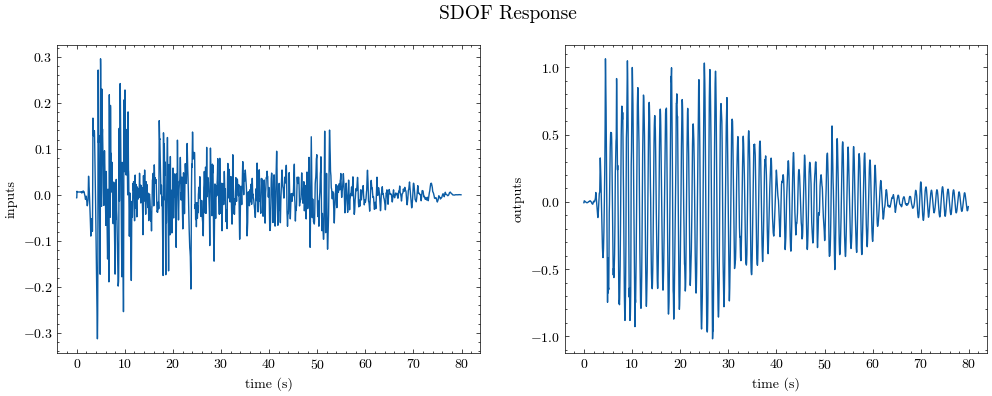

In [ ]:
plot_io(inputs=inputs, outputs=outputs, t=t, title="SDOF Response")

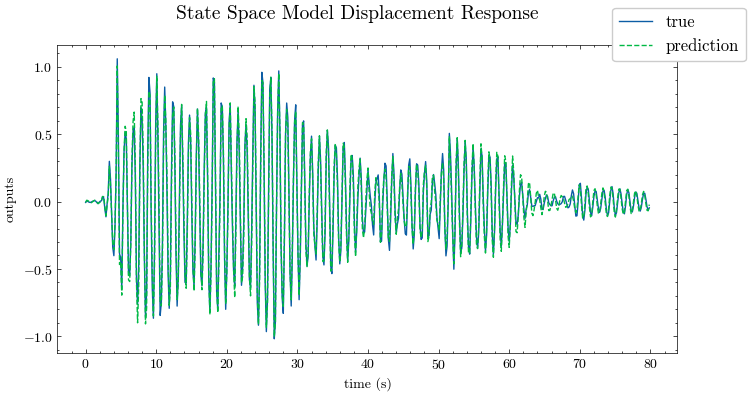

In [ ]:
# Reproduce the response with the state space model
from control import ss, forced_response
out_ssid = forced_response(ss(*realization,dt*conf.decimation), U=decimate(inputs,conf.decimation), squeeze=False, return_x=False).outputs
plot_pred(ytrue=decimate(outputs,conf.decimation), models=out_ssid, t=decimate(t,conf.decimation), title="State Space Model Displacement Response")